In [1]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn import tree

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

# Data Loading

In [2]:
%run ../util/load_data.py
%run ../util/data_visualization.py
%run ../util/outliers_statistics.py

import warnings
warnings.filterwarnings('ignore')

data = load_data("../data", aggregate=False)

/Users/andrluc/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/andrluc/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


# Classification

Let's create now the estimator pipeline.

In [4]:
classifier = Pipeline([
#     ('scl', StandardScaler()),
#     ('pca', PCA(n_components=5)),
    ('clf', xgb.XGBClassifier())
])

X = data['train_data'][data['numerical_attributes'] + data['categorical_attributes']]
y = data['train_data'][data['target']]

X.head()

,Aspect,Elevation,Hillshade_3pm,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Slope,Vertical_Distance_To_Hydrology,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
184,292,3221,165,212,238,1710,424,4401,3,49,...,0,0,0,0,0,0,1,0,0,0
188,107,2518,139,229,234,3522,360,553,5,39,...,0,0,0,0,0,0,1,0,0,0
193,116,3182,133,233,233,1854,579,4425,7,10,...,0,0,0,0,0,0,1,0,0,0
195,90,2515,125,233,227,3451,313,511,9,39,...,0,0,0,0,0,0,1,0,0,0
201,45,3231,147,221,231,1921,648,4173,4,59,...,0,0,0,0,0,0,1,0,0,0


## Learning curve

<module 'matplotlib.pyplot' from '/Users/andrluc/.pyenv/versions/3.6.4/lib/python3.6/site-packages/matplotlib/pyplot.py'>

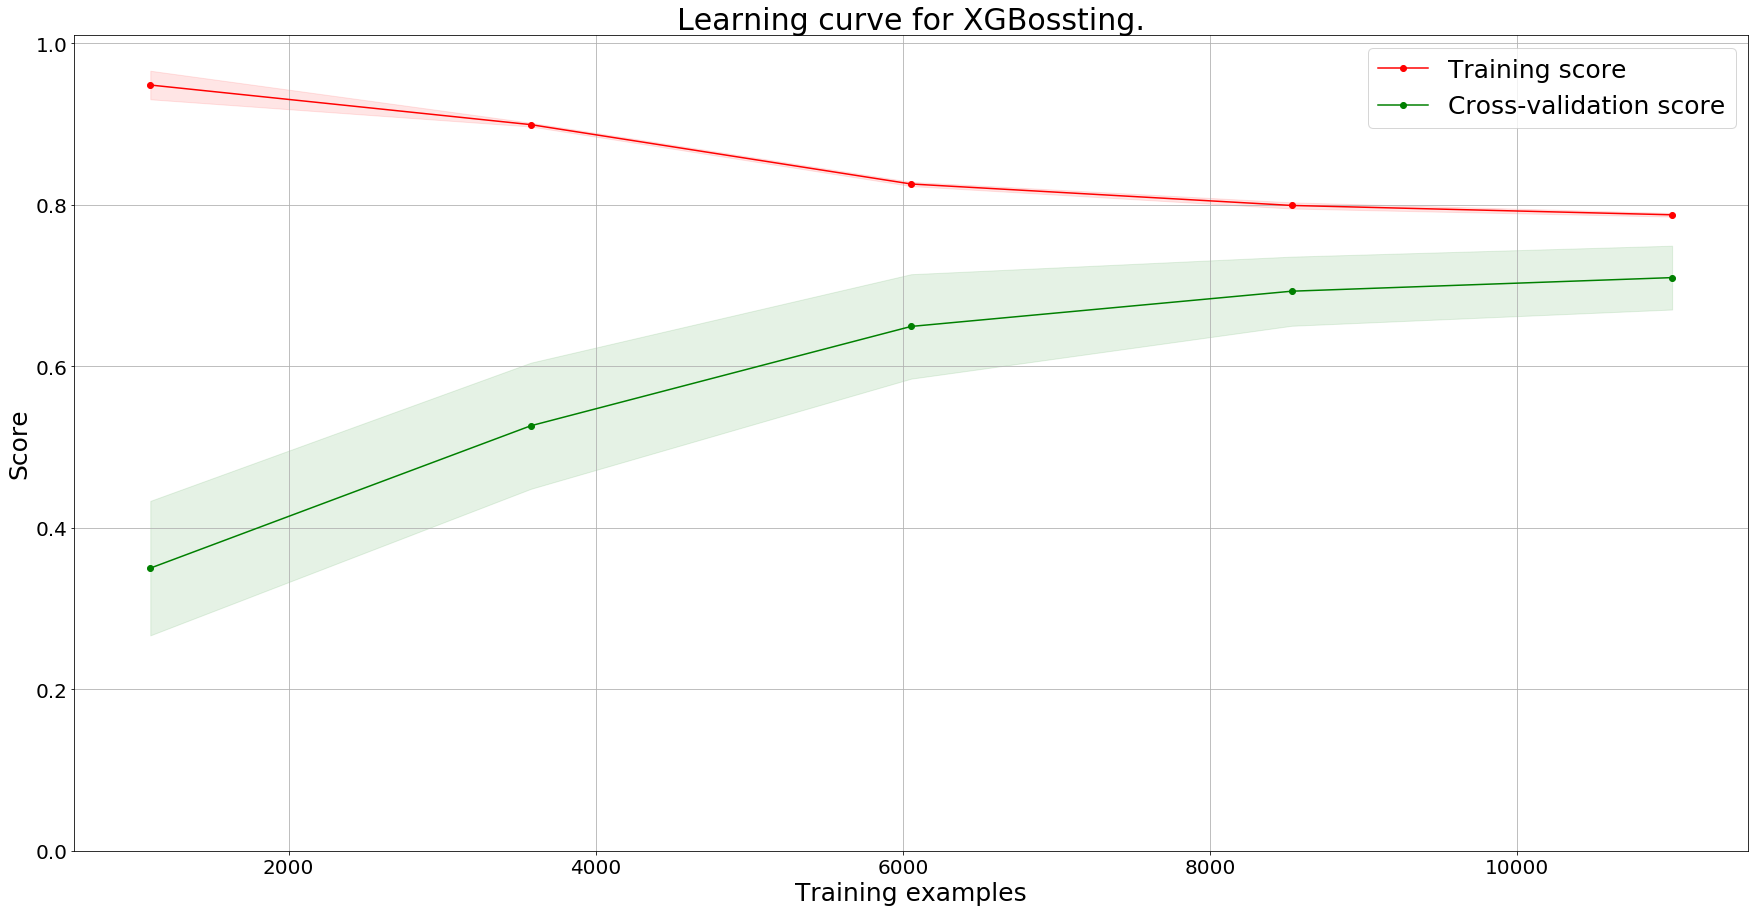

In [5]:
kfold = StratifiedKFold(n_splits = 10)
plot_learning_curve(classifier, 'Learning curve for XGBossting.', 
                    X, y, ylim=(0, 1.01), cv=kfold, n_jobs=25)

## Validation curve with tree max_depth

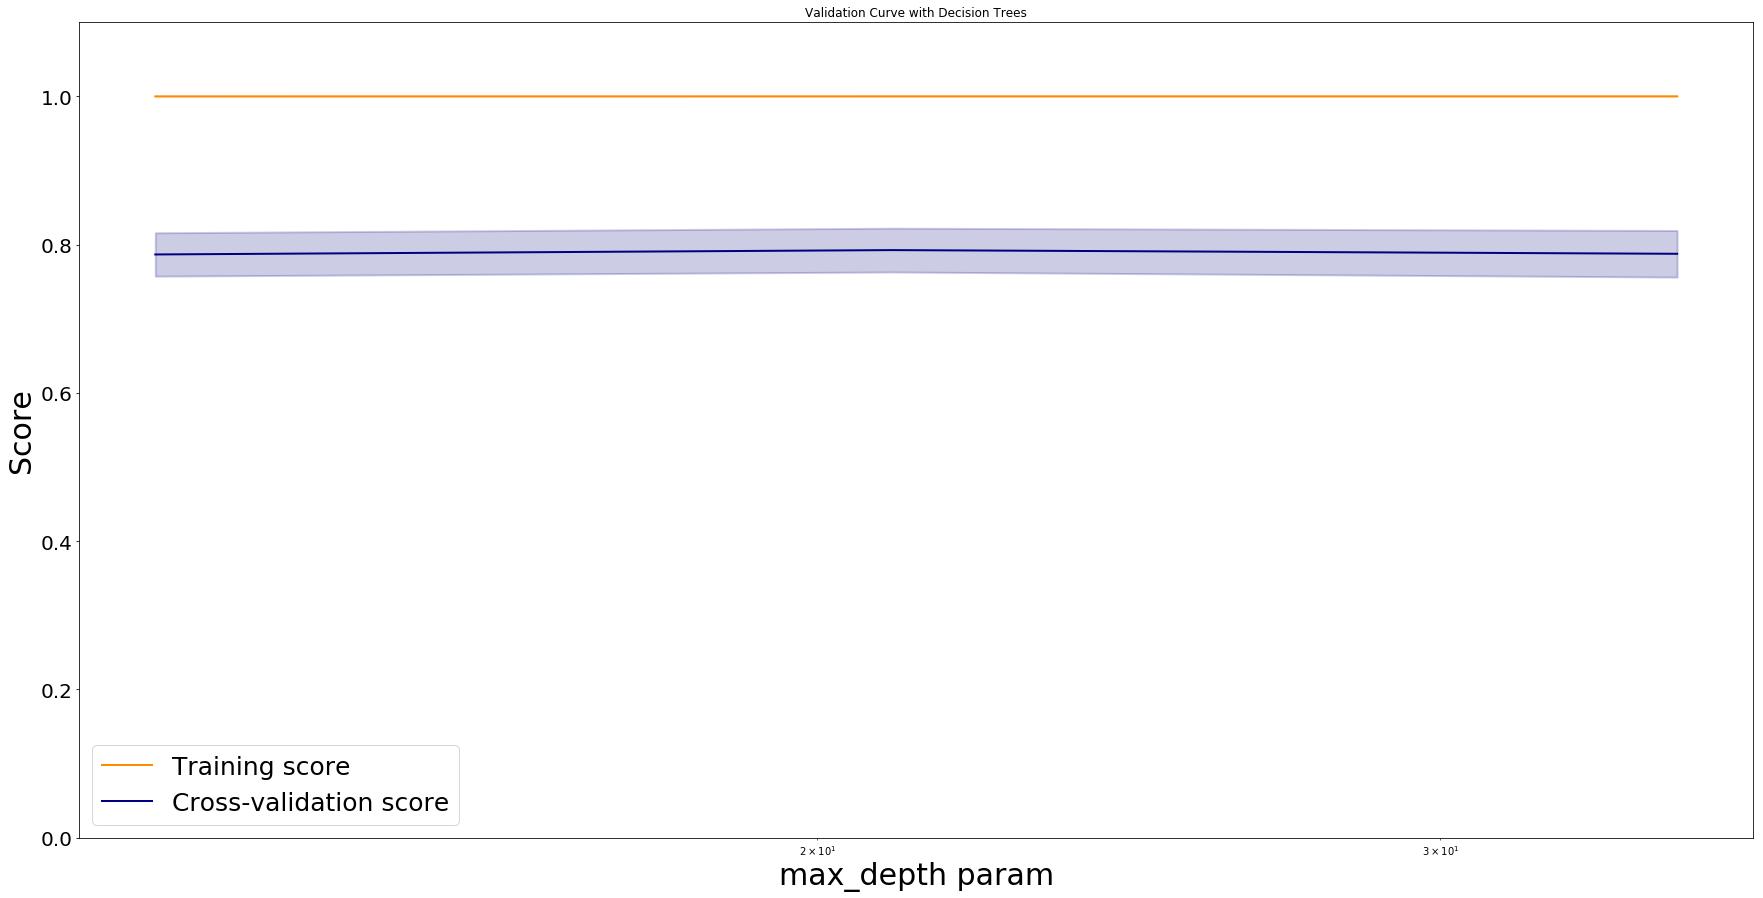

In [6]:
param_range = [13, 21, 35]

train_scores, test_scores = validation_curve(
    estimator = classifier,
    X = X,
    y = y,
    param_name = 'clf__max_depth',
    param_range = param_range,
    cv = 5
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(30, 15))
plt.title("Validation Curve with Decision Trees")
plt.xlabel("max_depth param", fontsize=30)
plt.ylabel("Score", fontsize=30)
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best", prop={'size': 25})
plt.tick_params(labelsize=20)

plt.show()


## Fetching the classifier results 

In [7]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

y_predicted_total = [None] * len(X)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    classifier.fit(X_train, y_train)
    
    y_predicted = classifier.predict(X_test).tolist()
    for idx, index in enumerate(test_index):
        y_predicted_total[index] = y_predicted[idx]

## Confusion matrix

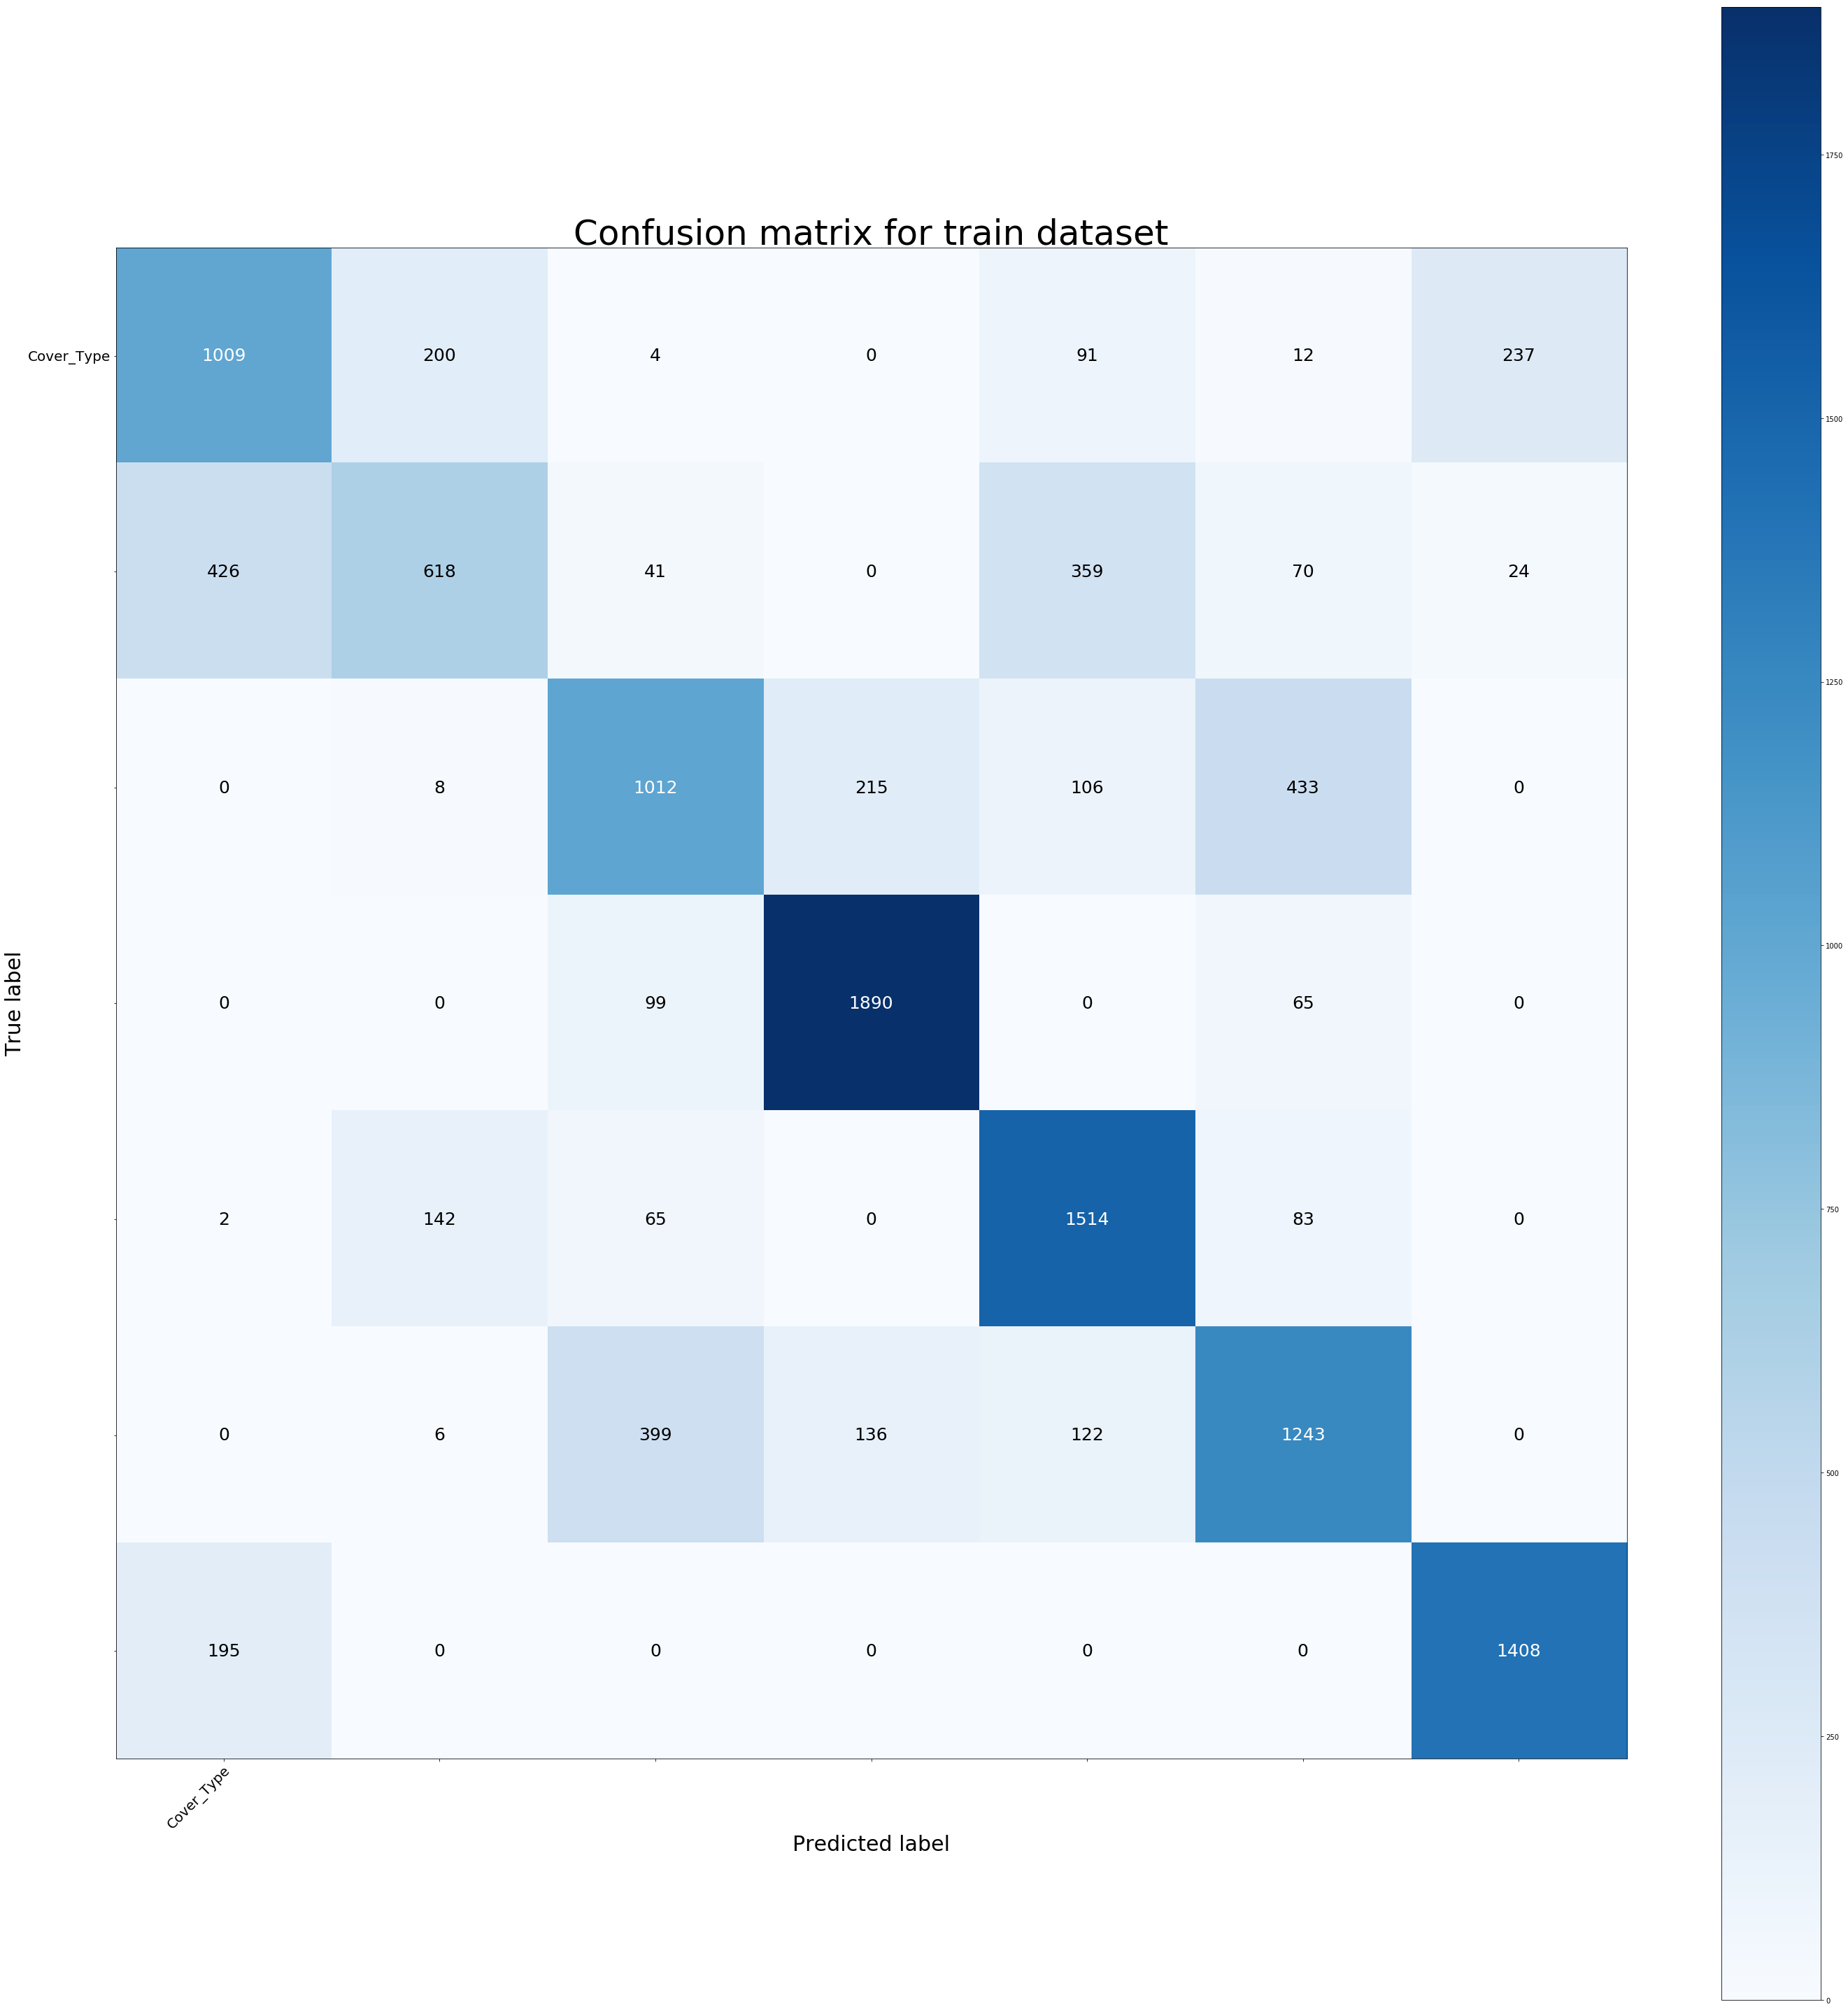

In [8]:
plot_confusion_matrix(y, y_predicted_total, classes=list(set(y[data['target']])),
                  title='Confusion matrix for train dataset')

## Classification results (precision, recall, F1-score)

In [ ]:
target_names = ['Class ' + str(index) for index in list(set(y[data['target'][0]].tolist()))]
print(classification_report(y, y_predicted_total, target_names=target_names))

              precision    recall  f1-score   support

     Class 1       0.62      0.65      0.63      1553
     Class 2       0.63      0.40      0.49      1538
     Class 3       0.62      0.57      0.60      1774
     Class 4       0.84      0.92      0.88      2054
     Class 5       0.69      0.84      0.76      1806
     Class 6       0.65      0.65      0.65      1906
     Class 7       0.84      0.88      0.86      1603

   micro avg       0.71      0.71      0.71     12234
   macro avg       0.70      0.70      0.70     12234
weighted avg       0.70      0.71      0.70     12234



## Hyperparameters optimization

In [ ]:
print("Fitting the classifier to the training set")
t0 = time()

param_grid = {
    'clf__max_depth': [13, 21, 35],
    'clf__learning_rate': [0.1, 0.5],
    'clf__n_estimators': [100, 1000]
    
}

# xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
#        max_depth=21, min_child_weight=1, missing=None, n_estimators=1000,
#        n_jobs=1, nthread=None, objective='multi:softprob', random_state=42,
#        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#        silent=True, subsample=1)

search = GridSearchCV(classifier, param_grid, cv=3)

search = search.fit(X, y)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(search.best_estimator_)

Fitting the classifier to the training set


## Tree visualization

In [ ]:
tree.export_graphviz(classifier.named_steps['clf'], out_file='tree.dot', max_depth=2, 
                     feature_names=data['numerical_attributes'] + data['categorical_attributes'])

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')


